# 1. Quá trình dự báo trên mô hình LR

## Thêm thư viện

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
# from sklearn.utils import column_or_1d
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor

In [3]:
# Load data
df = pd.read_csv('btc_open.csv')
print(df)
name_col='open'

      Unnamed: 0 formatted_date          high           low          open  \
0              0     2014-09-17    468.174011    452.421997    456.859985   
1              1     2014-09-18    456.859985    413.104004    424.102997   
2              2     2014-09-19    427.834991    384.532013    394.673004   
3              3     2014-09-20    423.295990    389.882996    408.084991   
4              4     2014-09-21    412.425995    393.181000    399.100006   
...          ...            ...           ...           ...           ...   
3082        3082     2023-02-24  24103.705078  23007.072266  23200.125000   
3083        3083     2023-02-25  23210.210938  22861.558594  23174.150391   
3084        3084     2023-02-26  23654.367188  23084.220703  23561.451172   
3085        3085     2023-02-27  23857.890625  23205.878906  23521.837891   
3086        3086     2023-02-28  23585.384766  23077.650391  23171.025391   

             close       volume      adjclose  
0       457.334015     2105

In [4]:
# Process data
df['H-L'] = df['high'] - df['low']
# df['O-C'] = df['open'] - df['close']
ma_1 = 7
ma_2 = 14
ma_3 = 21
df[f'SMA_{ma_1}'] = df[name_col].rolling(window=ma_1).mean()
df[f'SMA_{ma_2}'] = df[name_col].rolling(window=ma_2).mean()
df[f'SMA_{ma_3}'] = df[name_col].rolling(window=ma_3).mean()

df[f'SD_{ma_1}'] = df[name_col].rolling(window=ma_1).std()
df[f'SD_{ma_3}'] = df[name_col].rolling(window=ma_3).std()
df.dropna(inplace=True)

# df.to_csv(f"../../predict/bitcoin_df_{name_col}.csv")
df.set_index('formatted_date')
df2=df.copy()

## Nạp dữ liệu từ file csv

In [5]:

split_x = df2[['high','low','close','H-L', f'SMA_{ma_1}', f'SMA_{ma_2}', f'SMA_{ma_3}', f'SD_{ma_1}', f'SD_{ma_3}','formatted_date']]
split_y = df2[[name_col]]

X_train, X_test,y_train, y_test = train_test_split(split_x,split_y ,
                                   random_state=104, 
                                   test_size=0.2, 
                                   shuffle=True)

## Chuẩn hóa dữ liệu

In [6]:
cols_x = ['high','low','close','H-L', f'SMA_{ma_1}', f'SMA_{ma_2}', f'SMA_{ma_3}', f'SD_{ma_1}', f'SD_{ma_3}']
cols_y = [name_col]
x_train = X_train[cols_x].values.reshape(-1, len(cols_x))
y_train = y_train[cols_y].values.reshape(-1, len(cols_y))
print(x_train.shape, y_train.shape)

(2453, 9) (2453, 1)


In [7]:

x_test = X_test[cols_x].values.reshape(-1, len(cols_x))
y_test = y_test[cols_y].values.reshape(-1, len(cols_y))
print(x_test.shape, y_test.shape)

(614, 9) (614, 1)


# 2. Quá trình dự đoán trên mô hình 


In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor

In [9]:
_gdm = ('gradient', GradientBoostingRegressor(learning_rate= 0.07, max_depth= 8, n_estimators= 1000, subsample= 0.3));
_elm = ('elasticnet', ElasticNet(alpha= 0.01, l1_ratio= 0.8, positive= True, random_state= 100, selection= 'random', tol= 0.2, warm_start= True));
_lsm = ('lasso', Lasso(alpha= 3.17, copy_X= True, fit_intercept= False, max_iter= 1, normalize= True, positive= False, precompute= False, random_state= None, selection= 'random', tol= 0.3, warm_start= False));
_ridge = ('ridge',Ridge(alpha= 0.0006, copy_X= True, fit_intercept= False, max_iter= 1, normalize= False, positive= True, random_state= None, solver= 'auto', tol= 0.001));
_lr = ('linear',LinearRegression())

In [10]:
from itertools import permutations 
perm = permutations([_lr, _gdm, _lsm, _ridge]) 
_estimator_elm = []
for i in list(perm): 
    _estimator_elm.append(i)

In [11]:
parameters = {'estimators':_estimator_elm,  
              'final_estimator':_elm}
elm_grid = GridSearchCV(StackingRegressor(estimators= None, final_estimator = None),parameters, scoring='r2', cv=None).fit(x_train, y_train.reshape(-1, 1))
print(elm_grid.best_params_)
elm_reg = StackingRegressor(estimators= elm_grid.best_params_["estimators"], final_estimator = elm_grid.best_params_["final_estimator"])
elm_reg.fit(x_train, y_train.reshape(-1, 1))
elm_pred = elm_reg.predict(x_test)

{'estimators': (('ridge', Ridge(alpha=0.0006, fit_intercept=False, max_iter=1, normalize=False,
      positive=True)), ('gradient', GradientBoostingRegressor(learning_rate=0.07, max_depth=8, n_estimators=1000,
                          subsample=0.3)), ('linear', LinearRegression()), ('lasso', Lasso(alpha=3.17, fit_intercept=False, max_iter=1, normalize=True,
      selection='random', tol=0.3))), 'final_estimator': ElasticNet(alpha=0.01, l1_ratio=0.8, positive=True, random_state=100,
           selection='random', tol=0.2, warm_start=True)}


,high,low,close,H-L,SMA_7,SMA_14,SMA_21,SD_7,SD_21,formatted_date,predict
1113,4352.310059,4210.419922,4229.359863,141.890137,4290.328544,4056.174962,3937.118559,101.384953,332.644431,2017-10-04,4228.830282
1806,10279.366211,9716.656250,9754.422852,562.709961,10166.290039,10303.493025,10631.181920,213.116021,636.466164,2019-08-28,9760.710839
2094,9938.297852,9263.069336,9321.781250,675.228516,9691.031250,9685.189174,9487.446150,179.664121,362.307465,2020-06-11,9327.838101
78,378.654999,367.759003,369.604004,10.895996,376.577567,371.467926,374.435570,3.859550,11.218254,2014-12-04,368.496333
711,574.038025,569.739990,573.911987,4.298035,578.781285,577.418065,580.328616,5.642911,7.210595,2016-08-28,572.770440


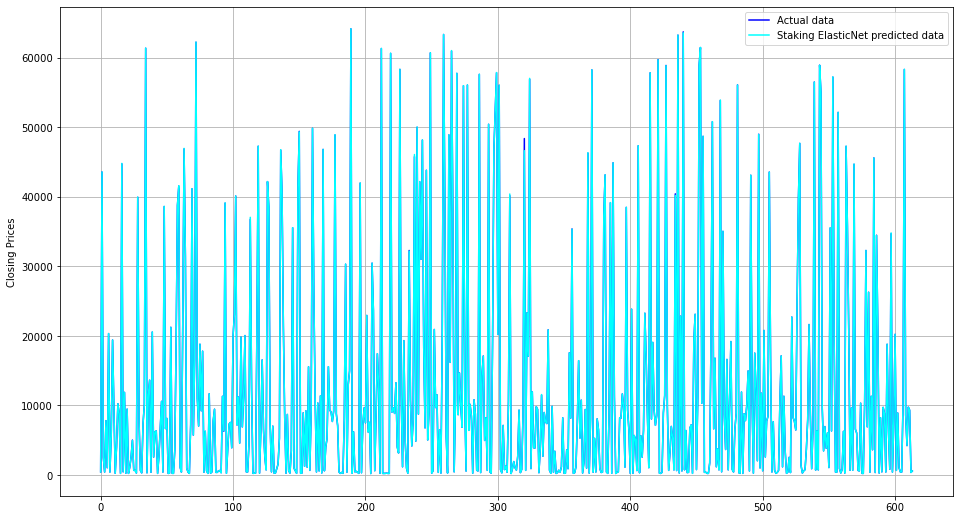

In [12]:

plt.figure(figsize=(16, 9))
plt.grid(True)
plt.ylabel('Closing Prices')
plt.plot(y_test, 'blue', label='Actual data')
plt.plot(elm_pred, 'cyan', label='Staking ElasticNet predicted data')
plt.legend()
X_test['predict']=elm_pred
X_test.tail()

In [13]:
mae = mean_absolute_error(y_test, elm_pred)
mape = mean_absolute_percentage_error(y_test, elm_pred)
mse = mean_squared_error(y_test, elm_pred)
rmse = np.sqrt(mse)
# r2 = r2_score(y_test, elm_pred)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
# print(f"R2: {r2:.2f}")

MAE: 12.43
MAPE: 0.19%
MSE: 5661.81
RMSE: 75.25
